In [0]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda')

In [0]:
#desired size of output image
imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
              transforms.Resize(imsize), #scale imported image
              transforms.ToTensor()     #transform it into a torch tensor
])

In [56]:
style_img = str(input("select style image : "))
style_img = Image.open(style_img)

content_img = str(input("select content image : "))
content_img = Image.open(content_img)


content_size = content_img.size

style_img = style_img.resize(content_size)


select style image : src/style.jpeg
select content image : src/content1.jpeg


In [0]:
import numpy as np

In [25]:
style_img.size

(859, 1280)

In [0]:
def image_loader(image):
  #image = Image.open(image_name)
  #fake batch dimension required to fit network's input dimensions
  image = loader(image).unsqueeze(0)

  return image.to(device, torch.float)


style_img = image_loader(style_img)
content_img = image_loader(content_img)

assert style_img.size() == content_img.size()

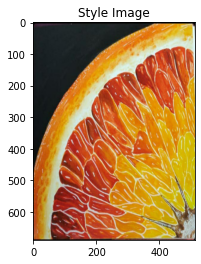

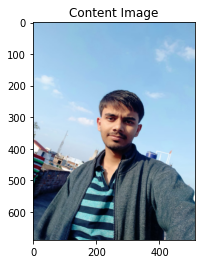

In [58]:
unloader = transforms.ToPILImage()

plt.ion()

def imshow(tensor,title=None):
  image = tensor.cpu().clone() #clone tensor to not do change on it
  image = image.squeeze(0)
  image = unloader(image)
  plt.imshow(image)
  if title is not None:
    plt.title(title)

  plt.pause(0.001)

plt.figure()
imshow(style_img, title='Style Image')
plt.figure()
imshow(content_img,title = 'Content Image')

In [59]:
content_image.shape

torch.Size([1, 3, 762, 512])

In [0]:
class ContentLoss(nn.Module):

  def __init__(self,target,):
    super(ContentLoss,self).__init__()
    #detach the target content from the tree used to dynamically compute
    #the gradient 
    #this is a stated value , not a variable. Otherwise the forward
    #method of the criterion will throw an error
    self.target = target.detach()

  def forward(self,input):
    self.loss = F.mse_loss(input,self.target)
    return input

In [0]:
def gram_matrix(input):
  a,b,c,d = input.size()
  # a = batch size 
  # b = no of feature maps
  # c,d = dimensions of bitmap

  features = input.view(a*b,c*d) #resize the F_XL

  G = torch.mm(features,features.t()) # compute the gram product

  return G.div(a*b*c*d)

In [0]:
class StyleLoss(nn.Module):

  def __init__(self,target_feature):
    super(StyleLoss,self).__init__()
    self.target = gram_matrix(target_feature).detach()

  def forward(self,input):
    G = gram_matrix(input)
    self.loss = F.mse_loss(G,self.target)
    return input

In [33]:
cnn = models.vgg19(pretrained = True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [0]:
torch.save(cnn,"src/model.pt")


In [0]:
cnn_normalization_mean = torch.tensor([0.485,0.456,0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229,0.224,225]).to(device)

#creating a module to normalize input image 

class Normalization(nn.Module):
  
  def __init__(self,mean,std):
    super(Normalization,self).__init__()

    self.mean = torch.tensor(mean).view(-1,1,1)
    self.std = torch.tensor(std).view(-1,1,1)


  def forward(self,img):
    #normalize image
    return (img - self.mean)/self.std

In [0]:
#desired depth layers to com[pute style/content losses
content_layers_default = ['conv_4']
style_layers_default = ["conv_1","conv_2","conv_3","conv_4","conv_5"]

def get_style_model_and_losses(cnn,normalization_mean, normalization_std,style_img,
                               content_img,content_layers = content_layers_default,
                               style_layers = style_layers_default):
  cnn = copy.deepcopy(cnn)

  normalization = Normalization(normalization_mean,normalization_std).to(device)

  content_losses=[]
  style_losses=[]
  #assuming that cnn is a nn.Sequential, so a new nn.Sequential to put
  #in modules that are supposed to be activated sequentially
  model = nn.Sequential(normalization)

  i=0
  for layer in cnn.children():
    if isinstance(layer,nn.Conv2d):
      i+=1
      name = 'conv_{}'.format(i)

    elif isinstance(layer,nn.ReLU):
      name = 'relu_{}'.format(i)

      layer = nn.ReLU(inplace=False)

    elif isinstance(layer,nn.MaxPool2d):
      name ='pool_{}'.format(i)

    elif isinstance(layer,nn.BatchNorm2d):
      name = 'bn_{}'.format(i)

    else:
      raise RuntimeError("Unrecognized layer : {}".format(layer.__class__.__name__))
    
    model.add_module(name,layer)

    if name in content_layers:
      target = model(content_img).detach()
      content_loss = ContentLoss(target)
      model.add_module("content_loss_{}".format(i),content_loss)
      content_losses.append(content_loss)

    if name in style_layers:
      target_feature = model(style_img).detach()
      style_loss = StyleLoss(target_feature)
      model.add_module("style_loss_{}".format(i),style_loss)
      style_losses.append(style_loss)

  #trimming off the layers after the last content and style losses

  for i in range(len(model)-1, -1,-1):
    if isinstance(model[i],ContentLoss) or isinstance(model[i],StyleLoss):
      break

  model = model[:(i+1)]

  return model,style_losses, content_losses

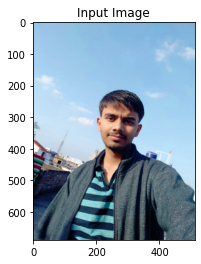

In [60]:
input_img = content_img.clone()

plt.figure()
imshow(input_img,title="Input Image")

In [0]:
def get_input_optimizer(input_img):
  optimizer = optim.LBFGS([input_img.requires_grad_()])
  return optimizer

In [0]:
def run_style_transfer(cnn,normalization_mean, normalization_std,
                       content_img,style_img,input_img,num_steps = 300,
                       style_weight = 1000000,content_weight = 1):
  '''Run the style transfer'''
  model,style_losses , content_losses = get_style_model_and_losses(cnn,normalization_mean,
                                                                normalization_std,style_img,content_img)
  optimizer = get_input_optimizer(input_img)

  print("Optimizing .....")
  run = [0]
  while run[0]<=num_steps:
    def closure():
      #correct values of updated image
      input_img.data.clamp_(0,1)

      optimizer.zero_grad()
      model(input_img)
      style_score = 0
      content_score = 0

      for sl in style_losses:
        style_score += sl.loss
      
      for cl in content_losses:
        content_score += cl.loss

      style_score *= style_weight
      content_score *= content_weight

      loss = style_score + content_score
      loss.backward()

      run[0]+=1

      if run[0]%50==0:
        print('run {}'.format(run))
        print('Style loss : {:4f} Content loss : {:4f}'.format(style_score.item(),
                                                                content_score.item()))
        print()
      
      return style_score + content_score
    optimizer.step(closure)
  
  #correcting values not in (0,1)
  input_img.data.clamp_(0,1)

  return input_img

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


Optimizing .....
run [50]
Style loss : 212.951019 Content loss : 14.905568

run [100]
Style loss : 51.070522 Content loss : 14.866065

run [150]
Style loss : 22.440620 Content loss : 14.738916

run [200]
Style loss : 12.175006 Content loss : 14.506479

run [250]
Style loss : 6.767397 Content loss : 14.209800

run [300]
Style loss : 4.122843 Content loss : 13.745733



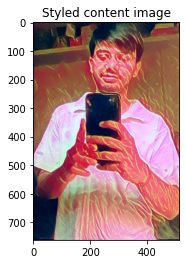

In [54]:
output = run_style_transfer(cnn,cnn_normalization_mean,cnn_normalization_std,
                            content_img,style_img,input_img)

plt.figure()
imshow(output,title="Styled content image")

plt.ioff()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


Optimizing .....
run [50]
Style loss : 150.551651 Content loss : 20.319376

run [100]
Style loss : 39.199192 Content loss : 19.760975

run [150]
Style loss : 17.860016 Content loss : 19.157789

run [200]
Style loss : 10.787930 Content loss : 18.337061

run [250]
Style loss : 6.348065 Content loss : 17.743145

run [300]
Style loss : 4.393539 Content loss : 17.013105



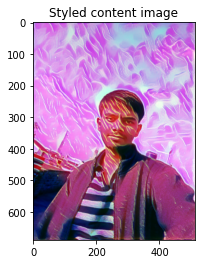

In [61]:
output = run_style_transfer(cnn,cnn_normalization_mean,cnn_normalization_std,
                            content_img,style_img,input_img)

plt.figure()
imshow(output,title="Styled content image")

plt.ioff()
plt.show()

In [79]:
input_img.shape

torch.Size([1, 3, 689, 512])

In [0]:
from torchvision.utils import save_image

#images.shape #torch.Size([64,3,28,28])
img1 = input_img[0] #torch.Size([3,28,28]
# img1 = img1.numpy() # TypeError: tensor or list of tensors expected, got <class 'numpy.ndarray'>
save_image(img1, 'src/t1.jpeg')

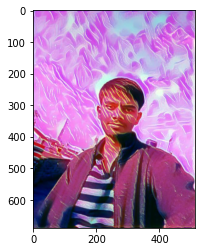

In [81]:
x = plt.imread("src/t1.jpeg")
plt.imshow(x)